### Importing Packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

#### Importing the Data

In [21]:
df = pd.read_csv('..\Data\Train_TEC_mar17.csv')
# df = pd.read_csv('../Data/TotalWithMissing.csv')

In [22]:
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


#### Dropping Useless columns

In [23]:
df.drop(["Date","Month","Year","Time","LT"], axis = 1, inplace = True)

In [24]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


#### Converting it into a ndarray

In [25]:
training_set = df.iloc[:,:].values

In [26]:
type(training_set), training_set.shape

(numpy.ndarray, (22320, 1))

#### Plotting the Data

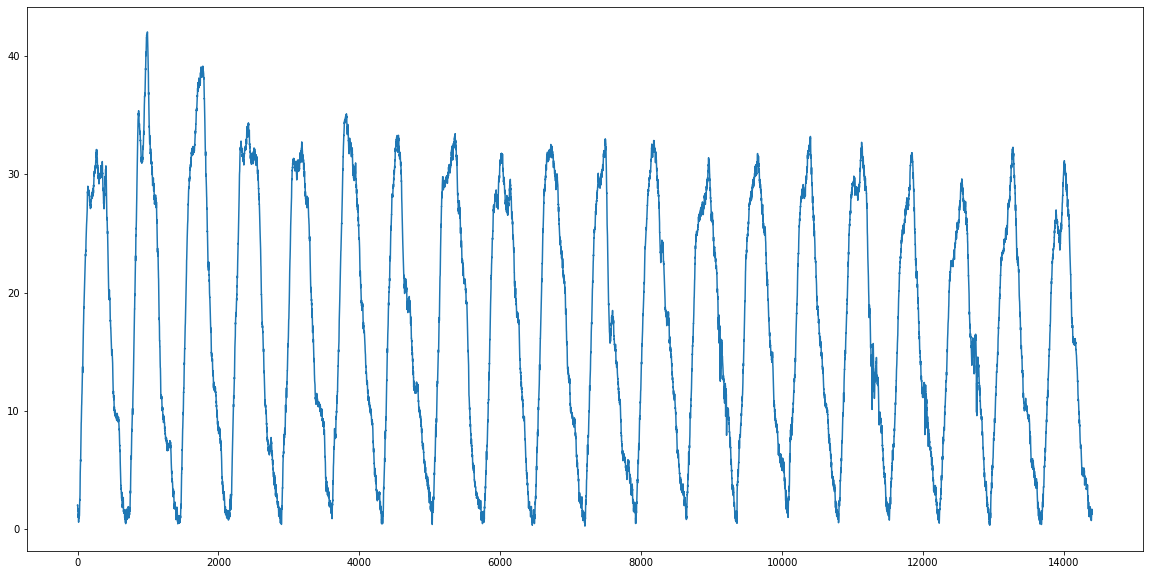

In [27]:
plt.figure(figsize=(20,10))

plt.plot(training_set, label = 'TEC Values')
plt.show()

#### Making Data Sequential for look back

In [28]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()

training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.90)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [29]:
training_data[-5:],x[0].shape, x[0], x[1], y

(array([[nan],
        [nan],
        [nan],
        [nan],
        [nan]]),
 (4, 1),
 array([[0.04266831],
        [0.04303103],
        [0.04115251],
        [0.03474105]]),
 array([[0.04303103],
        [0.04115251],
        [0.03474105],
        [0.03526637]]),
 array([[0.03526637],
        [0.03025557],
        [0.03485417],
        ...,
        [       nan],
        [       nan],
        [       nan]]))

In [30]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [31]:
# num_epochs = 1000
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: nan
Epoch: 1, loss: nan
Epoch: 2, loss: nan
Epoch: 3, loss: nan
Epoch: 4, loss: nan
Epoch: 5, loss: nan
Epoch: 6, loss: nan
Epoch: 7, loss: nan
Epoch: 8, loss: nan
Epoch: 9, loss: nan
Epoch: 10, loss: nan
Epoch: 11, loss: nan
Epoch: 12, loss: nan
Epoch: 13, loss: nan
Epoch: 14, loss: nan
Epoch: 15, loss: nan
Epoch: 16, loss: nan
Epoch: 17, loss: nan
Epoch: 18, loss: nan
Epoch: 19, loss: nan
Epoch: 20, loss: nan
Epoch: 21, loss: nan
Epoch: 22, loss: nan
Epoch: 23, loss: nan
Epoch: 24, loss: nan
Epoch: 25, loss: nan
Epoch: 26, loss: nan
Epoch: 27, loss: nan
Epoch: 28, loss: nan
Epoch: 29, loss: nan
Epoch: 30, loss: nan
Epoch: 31, loss: nan
Epoch: 32, loss: nan
Epoch: 33, loss: nan
Epoch: 34, loss: nan
Epoch: 35, loss: nan
Epoch: 36, loss: nan
Epoch: 37, loss: nan
Epoch: 38, loss: nan
Epoch: 39, loss: nan
Epoch: 40, loss: nan
Epoch: 41, loss: nan
Epoch: 42, loss: nan
Epoch: 43, loss: nan
Epoch: 44, loss: nan
Epoch: 45, loss: nan
Epoch: 46, loss: nan
Epoch: 47, loss: nan
Ep

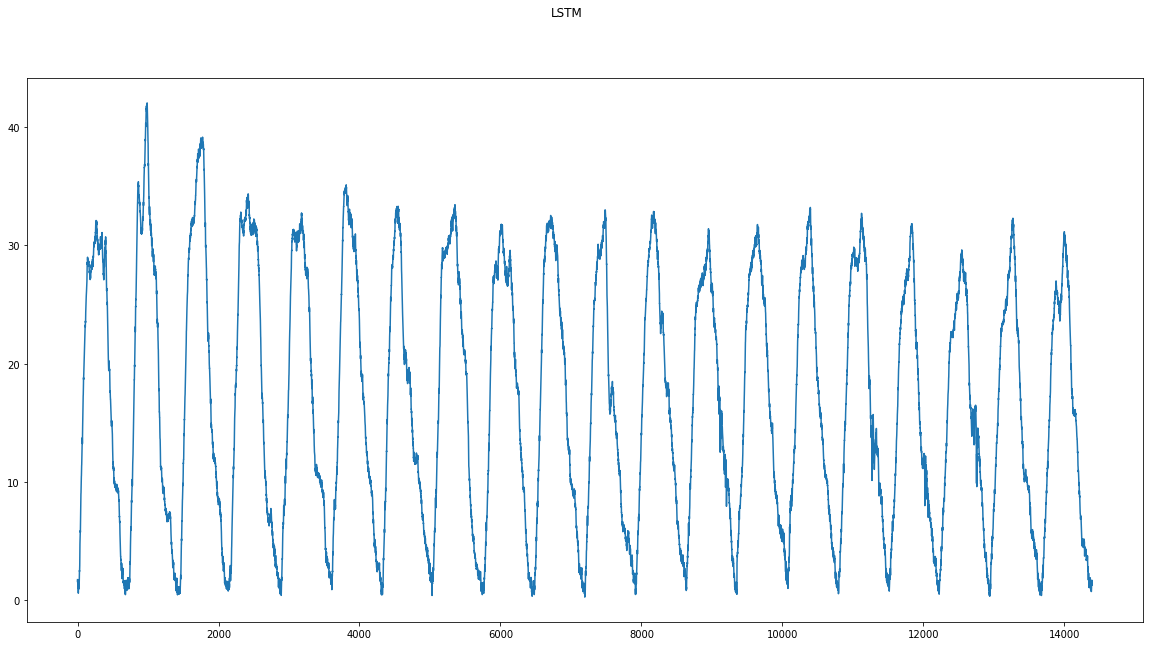

In [33]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(20,10))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('LSTM')
plt.show()

In [34]:
train_predict.shape

torch.Size([22315, 1])

In [35]:
dataY_plot.shape

(22315, 1)

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(dataY_plot, data_predict))

rms

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').